In [1]:
from pymongo import MongoClient
client = MongoClient('localhost', 27017)
db = client.cuore_thermalmodeldata

import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as pltz
from matplotlib.pylab import *
import scipy
from scipy import signal
import scipy.optimize

In [2]:
#apply bessel filters to simulated pulse
def bessel_lowpass(cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.bessel(order, normal_cutoff, btype='low', analog=False)
    return b, a

def bessel_lowpass_filter(data):
    sampling = 8
    dur = 1e-3
    cutoff = 18
    samplingRate = 1.0/(sampling*dur)
    order = 6
    b, a = bessel_lowpass(cutoff, samplingRate, order)
    y = signal.filtfilt(b, a, data)
    return y

def getchi2(pulse, testpulse):
    indexMax = argmax(pulse)
    return sum(abs(np.divide(np.power((pulse-testpulse)[indexMax:],2),testpulse[indexMax:])))

In [3]:
#import test pulse
c_avg='data/testPulse.csv'
c_averagePulseArray = np.genfromtxt(c_avg,delimiter=",")[:,1]
testPulse = c_averagePulseArray - np.average(c_averagePulseArray[:125])

/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


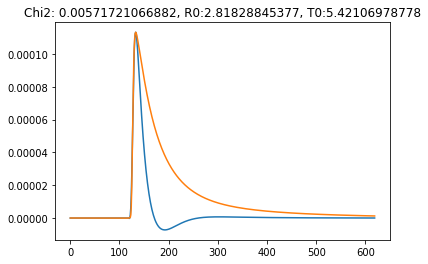

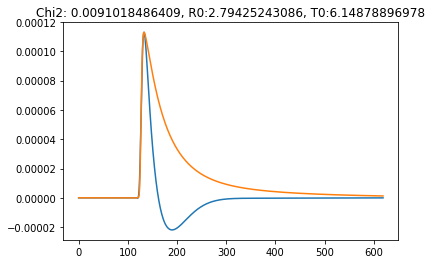

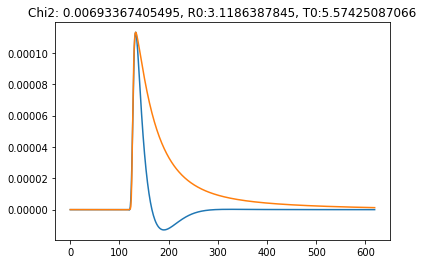

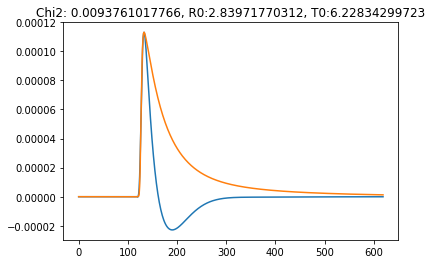

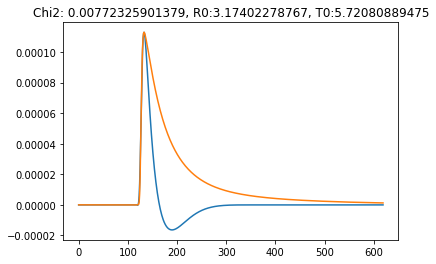

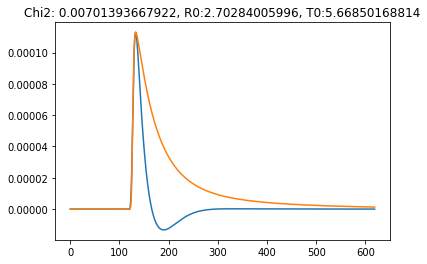

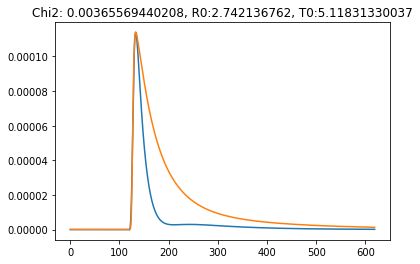

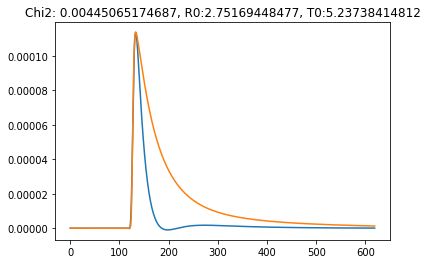

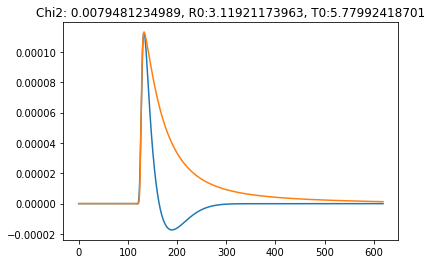

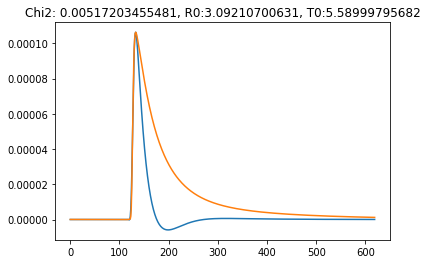

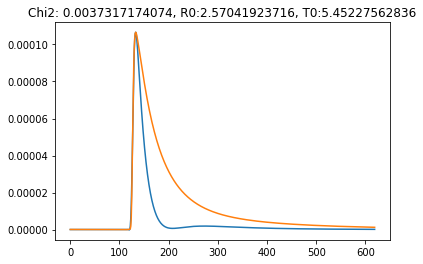

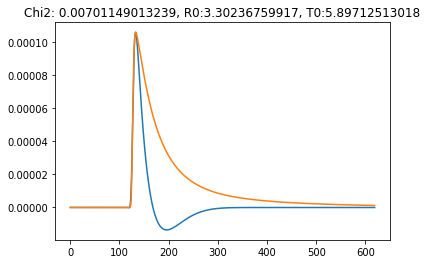

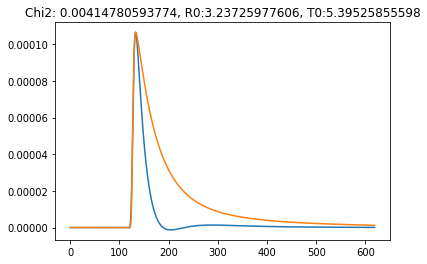

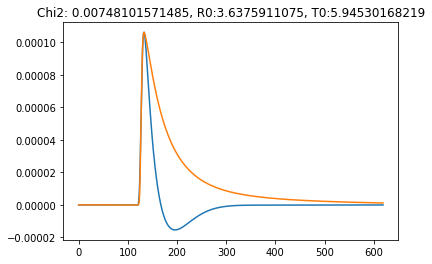

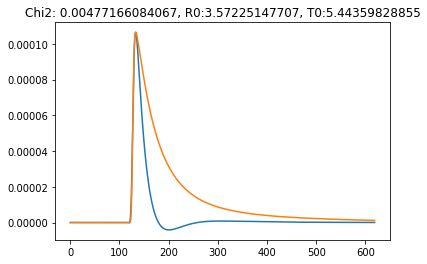

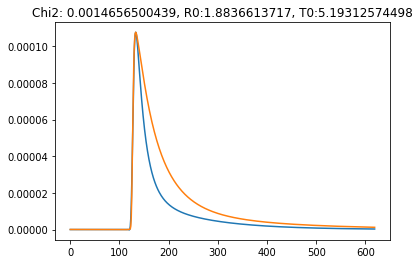

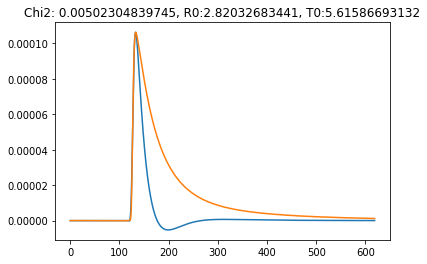

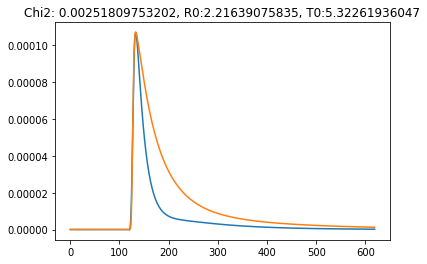

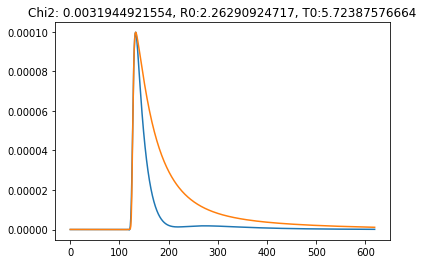

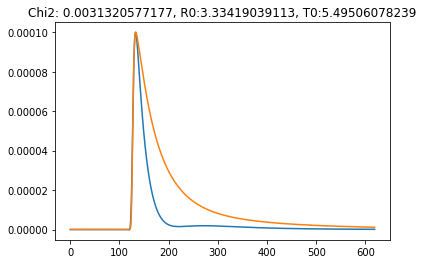

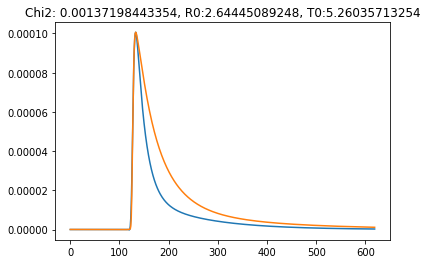

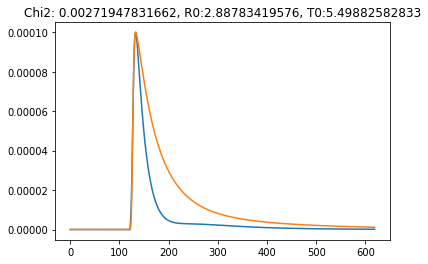

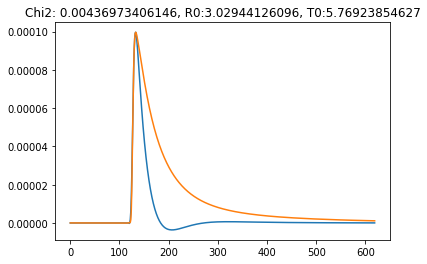

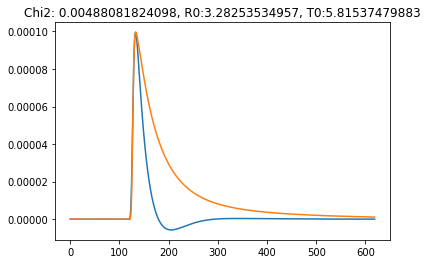

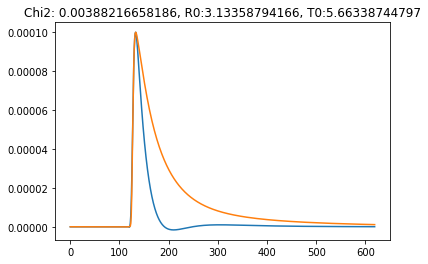

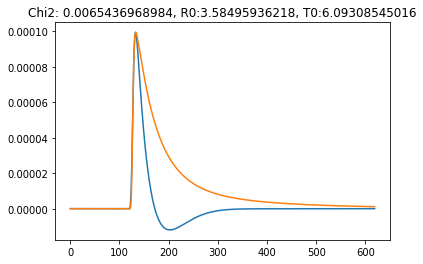

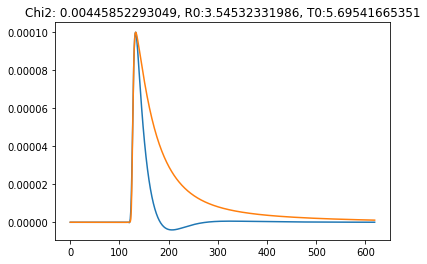

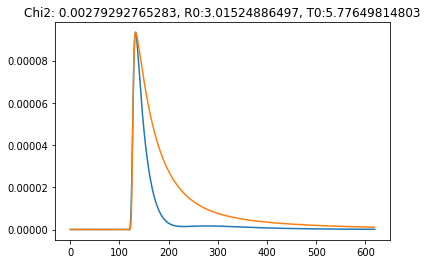

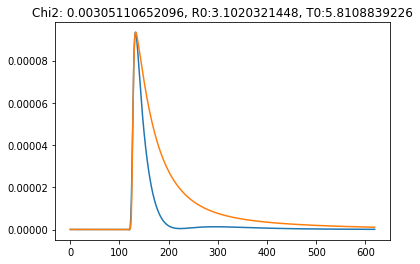

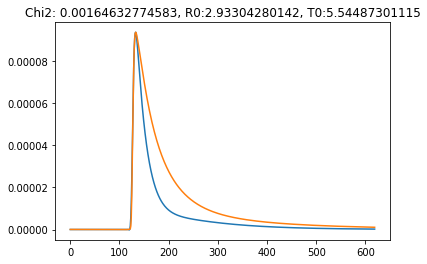

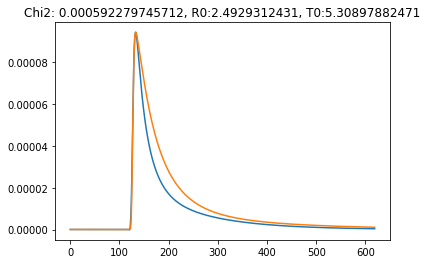

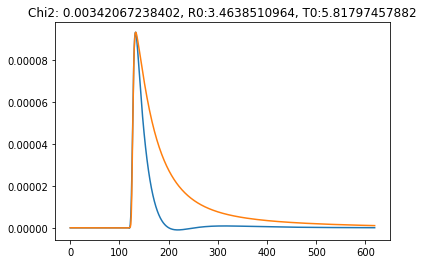

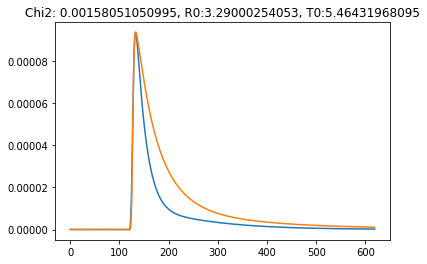

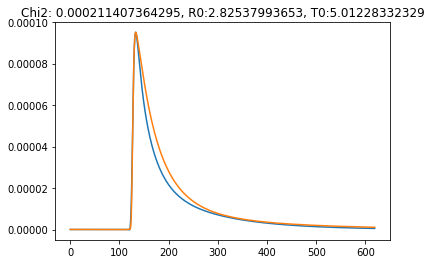

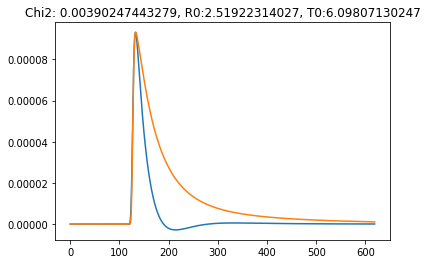

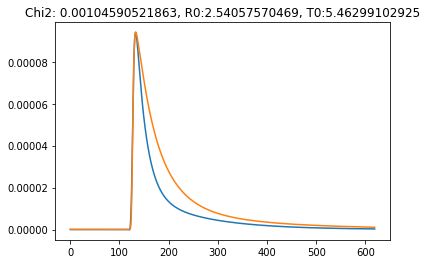

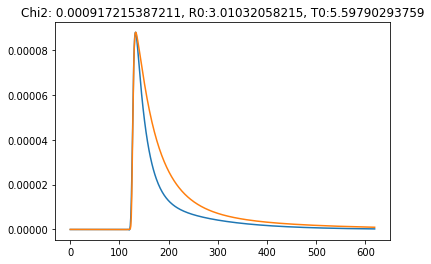

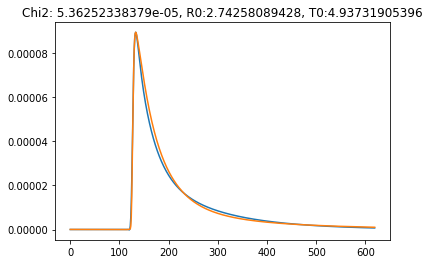

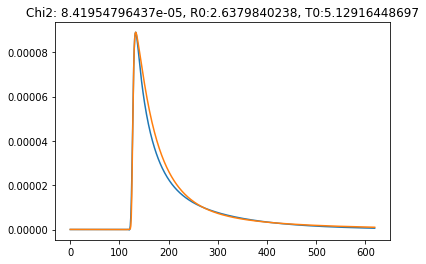

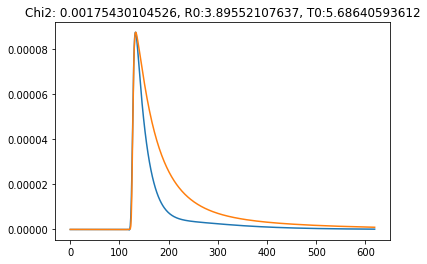

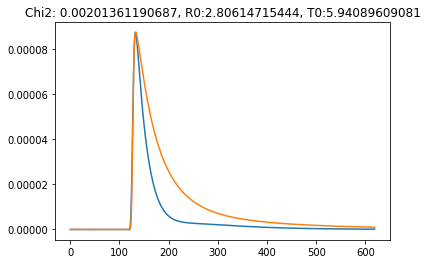

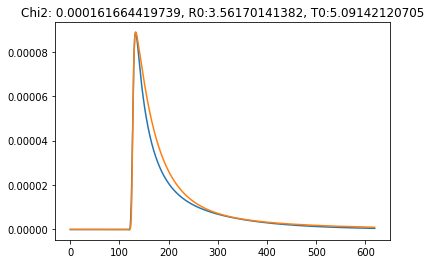

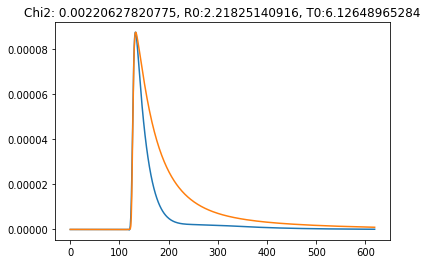

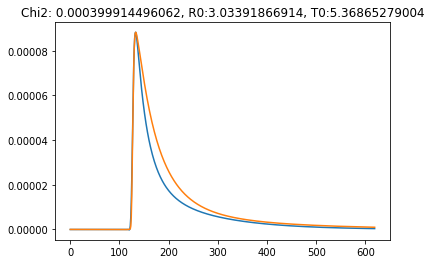

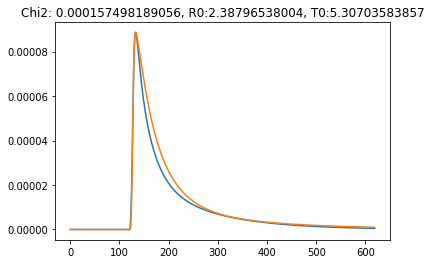

In [5]:
cursor = db.testdata.find({'model_info.test_number':2})

r0_array, t0_array, chi2_array = [],[],[]

def expFit(x,a,b,t1,t2,t3):
    return a*(-1*np.exp(-1*np.divide(x,t1))+b*np.exp(-1*np.divide(x,t2))+(1-b)*np.exp(-1*np.divide(x,t2)))+0.015

for document in cursor:
    r0 = document["thermal_parameters"]["R0"]
    r0_array.append(r0)
    t0 = document["thermal_parameters"]["T0"]  
    t0_array.append(t0)
    #v = (document["data"]["f"])[:625]
    #r = r0*np.exp(np.power(np.divide(t0,b),(0.5)))
    #i = np.divide(v,r)
        
    pulse = bessel_lowpass_filter(np.subtract((document["data"]["b"])[:620],document["thermal_parameters"]["s"]))
    normTestPulse = np.multiply(testPulse, np.max(pulse)/np.max(testPulse))[5:625]
    
    plt.figure()
    plt.plot(pulse)
    plt.plot(normTestPulse) 
    chi2_array.append(chi2)
    plt.title('Chi2: ' + str(chi2) + ', R0:' + str(r0) + ', T0:' + str(t0))
    
    #try:    chi2 = getchi2(pulse,normTestPulse)

    #    popt, pcov = scipy.optimize.curve_fit(expFit,range(0,500),b[125:], (0.0001,0.9,2.6,20,94)) 
    #    plt.plot(range(0,500), expFit(range(0,500), *popt))
    #    r0_array.append(r0)
    #    t0_array.append(t0)
    #    plt.title(popt[2:])
    #    t1.append(popt[2])
    #    t2.append(popt[3])
    #    t3.append(popt[4])
        
    #except:
    #   print('Fit Failed')

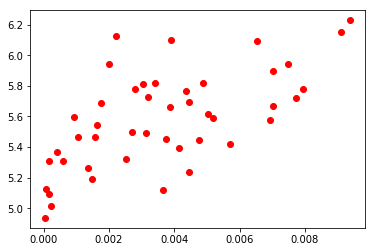

In [143]:
plt.plot(chi2_array,t0_array,'ro')

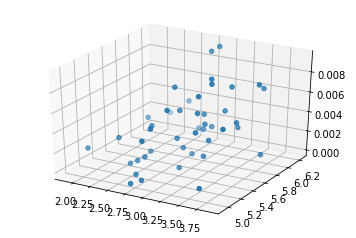

In [140]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(r0_array,t0_array,chi2_array)
